In [88]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Variables

In [2]:
export_path = '../data/exports/'

# Extract and cleanup data

## read all csv files in a single dataframe

In [81]:
df = pd.DataFrame()
for file in os.listdir(export_path):
    if file.endswith('csv'):
        file_path = os.path.join(export_path, file)
        temp_df = pd.read_csv(file_path, sep="\t")
        df = pd.concat ([df, temp_df], ignore_index=True)
df.head()

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,ROI: 2.00 µm per pixel: Channel 2: Mean,ROI: 2.00 µm per pixel: Channel 3: Mean,ROI: 2.00 µm per pixel: Channel 4: Mean,Area µm^2,Circularity,Max diameter µm
0,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,11c7fd04-d27a-4530-8ac6-bded6fb6dbe1,Detection,NaN,NeuN: Ignore*,Root object (Image),Polygon,521.58,1027.50,2498.2310,485.9515,5708.6719,1749.6309,0.6340,57.9731
1,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,91110308-a777-4cd7-a9a2-3e8dd8213e87,Detection,NaN,NeuN: Ignore*,Root object (Image),Polygon,534.44,420.34,2304.4277,470.6062,7909.5327,1438.6199,0.6716,46.5439
2,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,d4f6ca36-f020-4f7d-b75f-a95b466cf684,Detection,NaN,NeuN: Ignore*,Root object (Image),Polygon,449.20,840.17,2242.6550,540.9362,5585.7275,1407.6306,0.6724,48.1689
3,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,72ee3bd3-6112-46f9-a11e-41c15d4a6175,Detection,NaN,NeuN: Ignore*,Root object (Image),Polygon,423.20,443.01,2986.0923,408.4179,5963.9653,1399.7222,0.6416,51.6441
4,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,0a1f10be-8b17-4c47-8fef-7549a9472909,Detection,NaN,NeuN: Ignore*,Root object (Image),Polygon,376.54,594.90,2183.0437,488.5131,6229.8486,1390.6028,0.6359,51.7422


## Remove unwanted columns

In [82]:
df = df.drop(columns=[
    'Object ID',
    'Object type',
    'Name',
    'Parent',
    'ROI',
    'Centroid X µm',
    'Centroid Y µm',
])
df.head()

,Image,Classification,ROI: 2.00 µm per pixel: Channel 2: Mean,ROI: 2.00 µm per pixel: Channel 3: Mean,ROI: 2.00 µm per pixel: Channel 4: Mean,Area µm^2,Circularity,Max diameter µm
0,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2498.2310,485.9515,5708.6719,1749.6309,0.6340,57.9731
1,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2304.4277,470.6062,7909.5327,1438.6199,0.6716,46.5439
2,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2242.6550,540.9362,5585.7275,1407.6306,0.6724,48.1689
3,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2986.0923,408.4179,5963.9653,1399.7222,0.6416,51.6441
4,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2183.0437,488.5131,6229.8486,1390.6028,0.6359,51.7422


## Rename columns

In [83]:
df = df.rename(columns={
    'ROI: 2.00 µm per pixel: Channel 2: Mean': 'IB4_mean_intensity',
    'ROI: 2.00 µm per pixel: Channel 3: Mean': 'TREK1_mean_intensity',
    'ROI: 2.00 µm per pixel: Channel 4: Mean': 'NeuN_mean_intensity',
    'Area µm^2': 'area',
    'Circularity': 'circularity',
    'Max diameter µm': 'max_diameter'
})
df.head()

,Image,Classification,IB4_mean_intensity,TREK1_mean_intensity,NeuN_mean_intensity,area,circularity,max_diameter
0,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2498.2310,485.9515,5708.6719,1749.6309,0.6340,57.9731
1,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2304.4277,470.6062,7909.5327,1438.6199,0.6716,46.5439
2,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2242.6550,540.9362,5585.7275,1407.6306,0.6724,48.1689
3,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2986.0923,408.4179,5963.9653,1399.7222,0.6416,51.6441
4,DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F...,NeuN: Ignore*,2183.0437,488.5131,6229.8486,1390.6028,0.6359,51.7422


## Extract features from image file names

In [84]:
# look at the first image name
df.Image[0]

'DRG L F2_NeuN_IB4_Td-tomato_DAPI.lif - DRG L F2_coupe 1'

In [85]:
# get the DRG level by retrieving the 5th letter of Image column
df['level'] = df.Image.str[4]

# get the sex by retrieving the 7th letter of Image column
df['sex'] = df.Image.str[6]

# create a unique animal ID including level, sex, and number (8th letters of Image column)
df['animal'] = (df['level'] + df['sex'] + df['Image'].str[7])

# get the slice number by retrieving the last letter of Image column
df['slice'] = df.Image.str[-1].astype(int)

# get the cell number using cumulative count on data grouped by animal and slice
df['cell'] = df.groupby(['animal', 'slice']).cumcount() + 1

# remove the Image column and move our new columns first
df = df.drop(columns=['Image'])
new_cols =  ['level', 'sex', 'animal', 'slice', 'cell']
ordered_cols = new_cols + [c for c in df.columns if c not in new_cols]
df = df[ordered_cols]

df.head()

,level,sex,animal,slice,cell,Classification,IB4_mean_intensity,TREK1_mean_intensity,NeuN_mean_intensity,area,circularity,max_diameter
0,L,F,LF2,1,1,NeuN: Ignore*,2498.2310,485.9515,5708.6719,1749.6309,0.6340,57.9731
1,L,F,LF2,1,2,NeuN: Ignore*,2304.4277,470.6062,7909.5327,1438.6199,0.6716,46.5439
2,L,F,LF2,1,3,NeuN: Ignore*,2242.6550,540.9362,5585.7275,1407.6306,0.6724,48.1689
3,L,F,LF2,1,4,NeuN: Ignore*,2986.0923,408.4179,5963.9653,1399.7222,0.6416,51.6441
4,L,F,LF2,1,5,NeuN: Ignore*,2183.0437,488.5131,6229.8486,1390.6028,0.6359,51.7422


## Extract classification

In [86]:
# create new columns with booleans for each classification, based on the Classification column
df['NeuN'] = df['Classification'].str.contains('NeuN')
df['IB4'] = df['Classification'].str.contains('IB4')
df['TREK1'] = df['Classification'].str.contains('TREK1')
# delete column Classification
df = df.drop(columns=['Classification'])
df.head()

,level,sex,animal,slice,cell,IB4_mean_intensity,TREK1_mean_intensity,NeuN_mean_intensity,area,circularity,max_diameter,NeuN,IB4,TREK1
0,L,F,LF2,1,1,2498.2310,485.9515,5708.6719,1749.6309,0.6340,57.9731,True,False,False
1,L,F,LF2,1,2,2304.4277,470.6062,7909.5327,1438.6199,0.6716,46.5439,True,False,False
2,L,F,LF2,1,3,2242.6550,540.9362,5585.7275,1407.6306,0.6724,48.1689,True,False,False
3,L,F,LF2,1,4,2986.0923,408.4179,5963.9653,1399.7222,0.6416,51.6441,True,False,False
4,L,F,LF2,1,5,2183.0437,488.5131,6229.8486,1390.6028,0.6359,51.7422,True,False,False


# Plots

## Intensity distribution

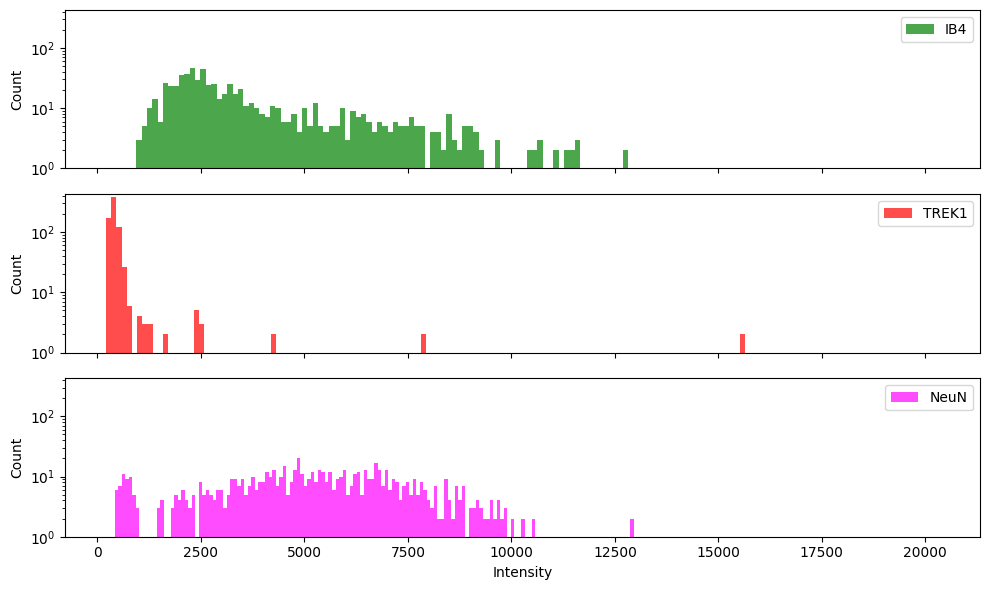

In [90]:
bins = 150

# Determine max count across all histograms for consistent y-axis
counts_ib4, _ = np.histogram(df['IB4_mean_intensity'], bins=bins)
counts_trek1, _ = np.histogram(df['TREK1_mean_intensity'], bins=bins)
counts_neun, _ = np.histogram(df['NeuN_mean_intensity'], bins=bins)
max_count = max(counts_ib4.max(), counts_trek1.max(), counts_neun.max())

# Create stacked subplots, remove spacing
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
plt.subplots_adjust(hspace=0)  # remove vertical spacing

# IB4
axes[0].hist(df['IB4_mean_intensity'], bins=bins, color='green', alpha=0.7, label='IB4')
axes[0].set_yscale('log')
axes[0].set_ylabel('Count')
axes[0].set_ylim(1, max_count * 1.1)
axes[0].legend(loc='upper right', frameon=True)

# TREK1
axes[1].hist(df['TREK1_mean_intensity'], bins=bins, color='red', alpha=0.7, label='TREK1')
axes[1].set_yscale('log')
axes[1].set_ylabel('Count')
axes[1].set_ylim(1, max_count * 1.1)
axes[1].legend(loc='upper right', frameon=True)

# NeuN
axes[2].hist(df['NeuN_mean_intensity'], bins=bins, color='magenta', alpha=0.7, label='NeuN')
axes[2].set_yscale('log')
axes[2].set_ylabel('Count')
axes[2].set_ylim(1, max_count * 1.1)
axes[2].set_xlabel('Intensity')
axes[2].legend(loc='upper right', frameon=True)

# Remove extra space around plots
plt.tight_layout()
plt.show()

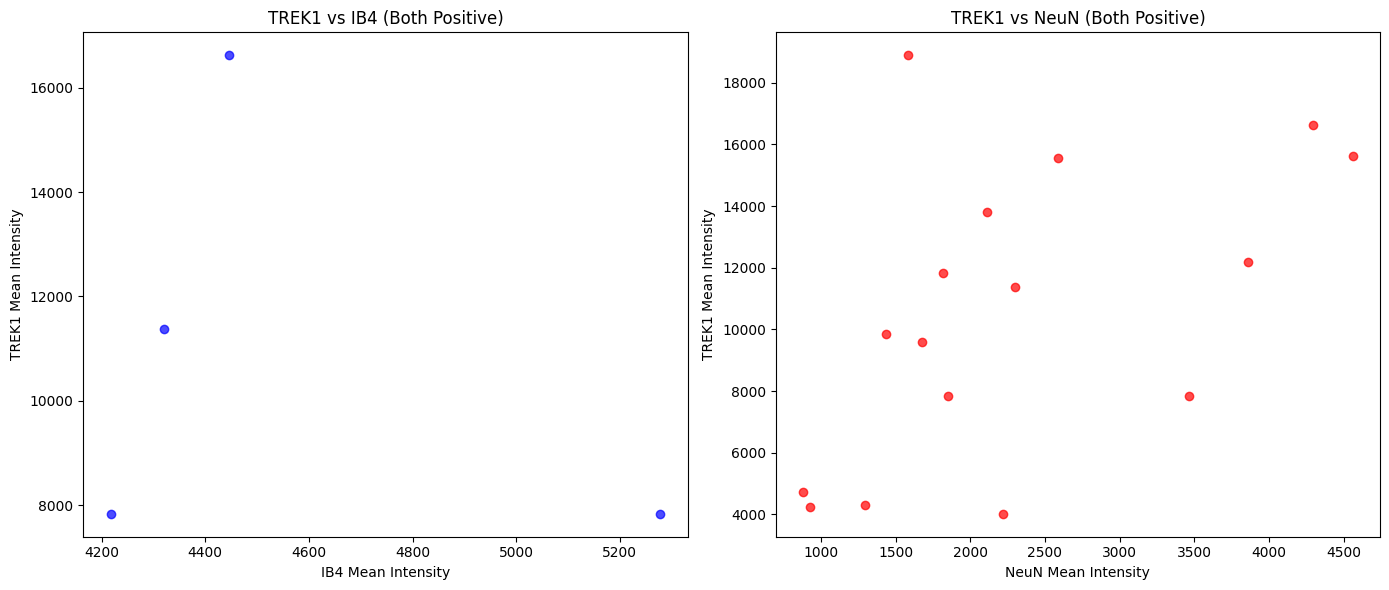

In [95]:
import matplotlib.pyplot as plt

# Filter for TREK1 vs IB4: only rows where both are True
df_trek1_ib4 = df[df['TREK1'] & df['IB4']]

# Filter for TREK1 vs NeuN: only rows where both are True
df_trek1_neun = df[df['TREK1'] & df['NeuN']]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter: TREK1 vs IB4
axes[0].scatter(df_trek1_ib4['IB4_mean_intensity'], 
                df_trek1_ib4['TREK1_mean_intensity'], 
                alpha=0.7, color='blue')
axes[0].set_xlabel('IB4 Mean Intensity')
axes[0].set_ylabel('TREK1 Mean Intensity')
axes[0].set_title('TREK1 vs IB4 (Both Positive)')

# Scatter: TREK1 vs NeuN
axes[1].scatter(df_trek1_neun['NeuN_mean_intensity'], 
                df_trek1_neun['TREK1_mean_intensity'], 
                alpha=0.7, color='red')
axes[1].set_xlabel('NeuN Mean Intensity')
axes[1].set_ylabel('TREK1 Mean Intensity')
axes[1].set_title('TREK1 vs NeuN (Both Positive)')

plt.tight_layout()
plt.show()


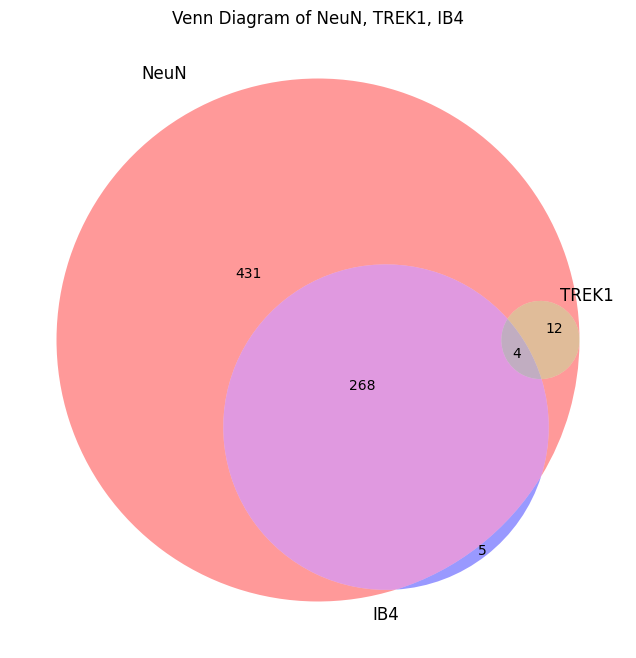

In [94]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Calculate the counts for the Venn diagram
neuN = df['NeuN']
trek1 = df['TREK1']
ib4 = df['IB4']

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn3(
    subsets=(
        sum(neuN & ~trek1 & ~ib4),       # NeuN only
        sum(trek1 & ~neuN & ~ib4),       # TREK1 only
        sum(neuN & trek1 & ~ib4),        # NeuN & TREK1
        sum(ib4 & ~neuN & ~trek1),       # IB4 only
        sum(neuN & ib4 & ~trek1),        # NeuN & IB4
        sum(trek1 & ib4 & ~neuN),        # TREK1 & IB4
        sum(neuN & trek1 & ib4)          # All three
    ),
    set_labels=('NeuN', 'TREK1', 'IB4')
)

plt.title('Venn Diagram of NeuN, TREK1, IB4')
plt.show()
